# Arenstorf orbit

In this example we would like to present some adaptive time step methods in Ponio. We do that on Arenstorf orbit problem

$$
  \begin{cases}
    \ddot{x} = x + 2\dot{y} - \frac{1-\mu}{r_1^3}(x + \mu) - \frac{\mu}{r_2^3}(x-1+\mu) \\
    \ddot{y} = y - 2\dot{x} - \frac{1-\mu}{r_1^3}y - \frac{\mu}{r_2^3}y
  \end{cases}
$$

with initial conditon $(x,\dot{x},y,\dot{y})=(0.994, 0, 0, -2.001585106)$ and $r_1$ and $r_2$ done by

$$
  r_1 = \sqrt{(x+\mu)^2 + y^2},\qquad r_2 = \sqrt{(x-1+\mu)^2 + y^2}.
$$

Ponio solves only first order derivative in time, to do that we need to rewrite our problem with the folowing vector

$$
  \begin{pmatrix}
    y_1 \\ y_2 \\ y_3 \\ y_4
  \end{pmatrix}
  =
  \begin{pmatrix}
    x \\ y \\ \dot{x} \\ \dot{y}
  \end{pmatrix}
$$

the system becomes

$$
  \begin{cases}
    \dot{y}_1 = y_3 \\
    \dot{y}_2 = y_4 \\
    \dot{y}_3 = y_1 + 2y_4 - \frac{1-\mu}{r_1^3}(y_1 + \mu) - \frac{\mu}{r_2^3}(y_1-1+\mu) \\
    \dot{y}_4 = y_2 - 2y_3 - \frac{1-\mu}{r_1^3}y_2 - \frac{\mu}{r_2^3}y_2 \\
  \end{cases}
$$

We already present the Lawson splitting into a linear and a non-linear part:

$$
  \frac{\mathrm{d}}{\mathrm{d}t}\begin{pmatrix} y_1 \\ y_2 \\ y_3 \\ y_4 \end{pmatrix}
  =
  \underbrace{
  \begin{pmatrix}
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 1 \\
    1 & 0 & 0 & 2 \\
    0 & 1 &-2 & 0 \\
  \end{pmatrix}
  }_{L}
  \begin{pmatrix} y_1 \\ y_2 \\ y_3 \\ y_4 \end{pmatrix}
  +
  \underbrace{
  \begin{pmatrix} 0 \\ 0 \\ - \frac{1-\mu}{r_1^3}(y_1 + \mu) - \frac{\mu}{r_2^3}(y_1-1+\mu) \\ - \frac{1-\mu}{r_1^3}y_2 - \frac{\mu}{r_2^3}y_2 \end{pmatrix}
  }_{N(t,u)}
$$

In [1]:
import sympy as sp

L = sp.Matrix([
    [0,0,1,0],
    [0,0,0,1],
    [1,0,0,2],
    [0,1,-2,0],
])

t = sp.symbols(r"tau",real=True)

In [2]:
for ev in L.eigenvals():
    display(ev)

-I

I

$$
  \textrm{sp}(L) \subset i\mathbb{R} \implies \textrm{sp}(e^{\tau L})\subset \mathcal{C}(0,1), \forall \tau\in\mathbb{R}
$$
so the linear part of the Lawson splitting doesn't blow up, this is a good property for the stability of the method.

In [3]:
eL = sp.exp(t*L)
display(eL)

Matrix([
[tau*sin(tau) + cos(tau), -tau*cos(tau) + sin(tau),             tau*cos(tau),             tau*sin(tau)],
[tau*cos(tau) - sin(tau),  tau*sin(tau) + cos(tau),            -tau*sin(tau),             tau*cos(tau)],
[           tau*cos(tau),             tau*sin(tau), -tau*sin(tau) + cos(tau),  tau*cos(tau) + sin(tau)],
[          -tau*sin(tau),             tau*cos(tau), -tau*cos(tau) - sin(tau), -tau*sin(tau) + cos(tau)]])

We get an explicit form of $e^{\tau L}$, $\forall\tau\in\mathbb{R}$, so we don't need to compute numerically exponential at each step. Now we can write a special exponential function to return this matrix at each step.

In Ponio, exponential function for Lawson method gets the linear part times the time step:

```cppr
matrix_t exp( matrix_t const& M );
```

with `M = c_j*dt*L`. To get the time step of the stage, with this matrix we can get `M(0,2)`.

```cpp
Eigen::Matrix<double,4,4> exp ( Eigen::Matrix<double,4,4> const& M )
{
  double tau = M(0,2);
  double s = std::sin(tau), c = std::cos(tau);
  
  Eigen::Matrix<double,4,4> e;
  e << tau*s+c , -tau*c+s ,  tau*c   ,  tau*s   ,
       tau*c-s ,  tau*s+c , -tau*s   ,  tau*c   ,
       tau*c   ,  tau*s   , -tau*s+c ,  tau*c+s ,
      -tau*s   ,  tau*c   , -tau*c-s , -tau*s+c ;
  return e;
}
```

We can also use SymPy to generate the code

In [4]:
print("""
e <<
    {};
""".format(
    " ,\n    ".join([
        " , ".join([ sp.cxxcode(eL[i,j]) for j in range(eL.cols) ])
        for i in range(eL.rows)
    ])
))


e <<
    tau*std::sin(tau) + std::cos(tau) , -tau*std::cos(tau) + std::sin(tau) , tau*std::cos(tau) , tau*std::sin(tau) ,
    tau*std::cos(tau) - std::sin(tau) , tau*std::sin(tau) + std::cos(tau) , -tau*std::sin(tau) , tau*std::cos(tau) ,
    tau*std::cos(tau) , tau*std::sin(tau) , -tau*std::sin(tau) + std::cos(tau) , tau*std::cos(tau) + std::sin(tau) ,
    -tau*std::sin(tau) , tau*std::cos(tau) , -tau*std::cos(tau) - std::sin(tau) , -tau*std::sin(tau) + std::cos(tau);



Or for the shake of simplicity, use Eigen functions to compute exponential of a matrix:

```cpp
#include <unsupported/Eigen/MatrixFunctions>

// ...

auto mexp = [](Eigen::Matrix<double,4,4> const& M){ return M.exp(); };
```

In [5]:
%system mkdir -p arenstorf_adaptivetimestep_demo

[]

In [6]:
%%writefile arenstorf_adaptivetimestep_demo/main.cpp

#include <iostream>
#include <numeric>

#include <ponio/problem.hpp>
#include <ponio/solver.hpp>
#include <ponio/observer.hpp>
#include <ponio/runge_kutta.hpp>

#include <eigen3/Eigen/Core>

struct arenstorf_model
{
    using state_t = Eigen::Matrix<double,4,1>;
    using matrix_t = Eigen::Matrix<double,4,4>;
  
    double mu;
    matrix_t L;
  
    arenstorf_model(double m)
    : mu(m)
    {
        L << 0., 0., 1., 0.,
             0., 0., 0., 1.,
             1., 0., 0., 2.,
             0., 1.,-2., 0.;
    }
    
    double r_1 (double x, double y)
    {
        return std::sqrt((x+mu)*(x+mu) + y*y);
    }
    
    double r_2 (double x, double y)
    {
        return std::sqrt((x-1.+mu)*(x-1.+mu) + y*y);
    }
    
    state_t linear_part ( state_t const& y )
    {
        return L*y;
    }
    
    state_t non_linear_part ( state_t const& y )
    {
        double r1 = r_1(y[0], y[1]), r2 = r_2(y[0], y[1]);
        return {
            0.,
            0.,
            -(1-mu)*(y[0]+mu)/(r1*r1*r1) - mu*(y[0]-1+ mu)/(r2*r2*r2),
            -(1-mu)*y[1]/(r1*r1*r1) - mu*y[1]/(r2*r2*r2)
        };
    }
    
   
    state_t operator () (double t , state_t const& y)
    { 
       return linear_part(y) + non_linear_part(y);
    }
};

Eigen::Matrix<double,4,4> mexp ( Eigen::Matrix<double,4,4> const& M )
{
    double tau = M(0,2);
    double s = std::sin(tau), c = std::cos(tau);

    Eigen::Matrix<double,4,4> e;
    e << tau*s+c , -tau*c+s ,  tau*c   ,  tau*s   ,
         tau*c-s ,  tau*s+c , -tau*s   ,  tau*c   ,
         tau*c   ,  tau*s   , -tau*s+c ,  tau*c+s ,
        -tau*s   ,  tau*c   , -tau*c-s , -tau*s+c ;
    return e;
}

int main()
{
    using state_t = Eigen::Matrix<double,4,1>;
    using namespace ponio::observer;

    double mu = 0.012277471;
    auto A = arenstorf_model(mu);
    auto arenstorf_pb  = ponio::make_simple_problem(A);
    auto arenstorf_lpb = ponio::make_lawson_problem(
        A.L,
        [&A](double t, state_t const& y) -> state_t
        {
            return A.non_linear_part(y);
        }
    );
    
    state_t  yini = { 0.994, 0., 0., -2.00158510637908252240537862224 };

    double dt = 2e-5;
    double tf = 17.0652165601579625588917206249;
    double tol = 5e-6;

    ponio::solve(arenstorf_pb, ponio::runge_kutta::rk_118(tol), yini, {0.,tf}, dt, "arenstorf_adaptivetimestep_demo/orbit_rk_118_ref.txt"_fobs);
    
    ponio::solve(arenstorf_pb, ponio::runge_kutta::rk54_6m(tol), yini, {0.,tf}, dt, "arenstorf_adaptivetimestep_demo/orbit_rk56_6m.txt"_fobs);
    ponio::solve(arenstorf_pb, ponio::runge_kutta::rk54_7m(tol), yini, {0.,tf}, dt, "arenstorf_adaptivetimestep_demo/orbit_rk56_7m.txt"_fobs);
    ponio::solve(arenstorf_pb, ponio::runge_kutta::rk54_7s(tol), yini, {0.,tf}, dt, "arenstorf_adaptivetimestep_demo/orbit_rk56_7s.txt"_fobs);
    
    ponio::solve(arenstorf_lpb, ponio::runge_kutta::lrk54_6m(mexp,tol), yini, {0.,tf}, dt, "arenstorf_adaptivetimestep_demo/orbit_lrk56_6m.txt"_fobs);
    ponio::solve(arenstorf_lpb, ponio::runge_kutta::lrk54_7m(mexp,tol), yini, {0.,tf}, dt, "arenstorf_adaptivetimestep_demo/orbit_lrk56_7m.txt"_fobs);
    ponio::solve(arenstorf_lpb, ponio::runge_kutta::lrk54_7s(mexp,tol), yini, {0.,tf}, dt, "arenstorf_adaptivetimestep_demo/orbit_lrk56_7s.txt"_fobs);

    return 0;
}


Writing arenstorf_adaptivetimestep_demo/main.cpp


In [7]:
%system $CXX -std=c++20 -I ../include -I ${CONDA_PREFIX}/include arenstorf_adaptivetimestep_demo/main.cpp -o arenstorf_adaptivetimestep_demo/main

[]

In [8]:
%system ./arenstorf_adaptivetimestep_demo/main

[]

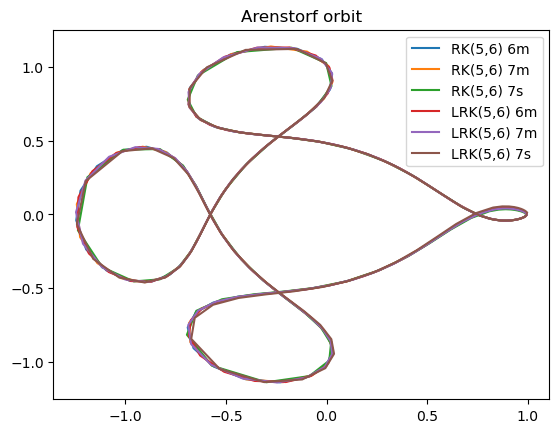

In [9]:
import numpy as np
import matplotlib.pyplot as plt

meths = {
    "rk56_6m": "RK(5,6) 6m",
    "rk56_7m": "RK(5,6) 7m",
    "rk56_7s": "RK(5,6) 7s",
    "lrk56_6m": "LRK(5,6) 6m",
    "lrk56_7m": "LRK(5,6) 7m",
    "lrk56_7s": "LRK(5,6) 7s"    
}

for tag,name in meths.items():
    data = np.loadtxt("arenstorf_adaptivetimestep_demo/orbit_{}.txt".format(tag))
    t = data[:,0]
    x = data[:,1]
    y = data[:,2]
    plt.plot(x,y,label=name)

plt.title("Arenstorf orbit")
plt.legend()
plt.show()

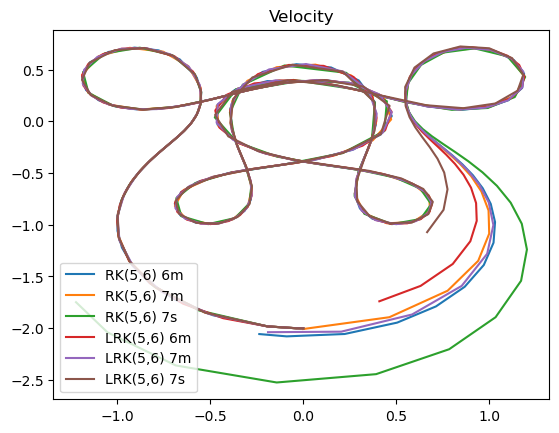

In [10]:
for tag,name in meths.items():
    data = np.loadtxt("arenstorf_adaptivetimestep_demo/orbit_{}.txt".format(tag))
    t = data[:,0]
    u = data[:,3]
    v = data[:,4]
    plt.plot(u,v,label=name)

plt.title("Velocity")
plt.legend()
plt.show()

Since $y_1$ and $y_2$ are linear in the solved problem, we observe fewer differences, contrary to the speed. The exact solution is a closed orbit (so near to the orange curve done by RK(5,6) 7m method).

Ponio save also the time step of each iteration (even failed iterations).

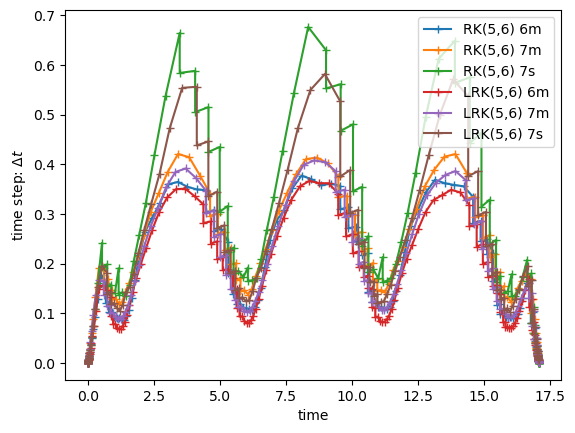

In [11]:
for tag,name in meths.items():
    data = np.loadtxt("arenstorf_adaptivetimestep_demo/orbit_{}.txt".format(tag))
    t  = data[:,0]
    dt = data[:,-1]
    plt.plot(t,dt,"+-",label=name)

plt.xlabel("time")
plt.ylabel("time step: $\\Delta t$")
plt.legend()
plt.show()

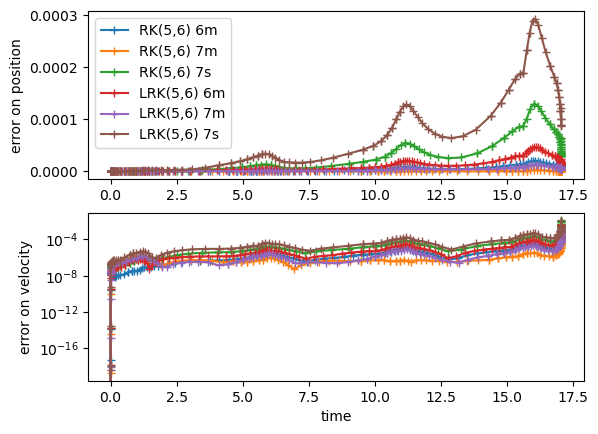

In [12]:
from scipy.interpolate import interp1d

data_ref = np.loadtxt("arenstorf_adaptivetimestep_demo/orbit_rk_118_ref.txt")
t_ref = data_ref[:,0]
x_ref = data_ref[:,1]
y_ref = data_ref[:,2]
u_ref = data_ref[:,3]
v_ref = data_ref[:,4]

fx = interp1d(t_ref,x_ref,kind='cubic')
fy = interp1d(t_ref,y_ref,kind='cubic')

fu = interp1d(t_ref,u_ref,kind='cubic')
fv = interp1d(t_ref,v_ref,kind='cubic')

def error(u,v):
    return np.sqrt(np.square(u-v))/len(u)

fig, axs = plt.subplots(2, 1)

for tag,name in meths.items():
    data = np.loadtxt("arenstorf_adaptivetimestep_demo/orbit_{}.txt".format(tag))
    t  = data[:,0]
    x = data[:,1]
    y = data[:,2]
    u = data[:,3]
    v = data[:,4]
    axs[0].plot(t,error(x,fx(t)) + error(y,fy(t)),"+-",label=name)
    axs[1].plot(t,error(u,fu(t)) + error(v,fv(t)),"+-",label=name)

axs[0].set_ylabel("error on position")

axs[1].set_yscale('log')
axs[1].set_xlabel("time")
axs[1].set_ylabel("error on velocity")

axs[0].legend()
plt.show()

As we already see on the velocity curve, the method that done the lower error is the RK(5,6) 7m method (orange curve).

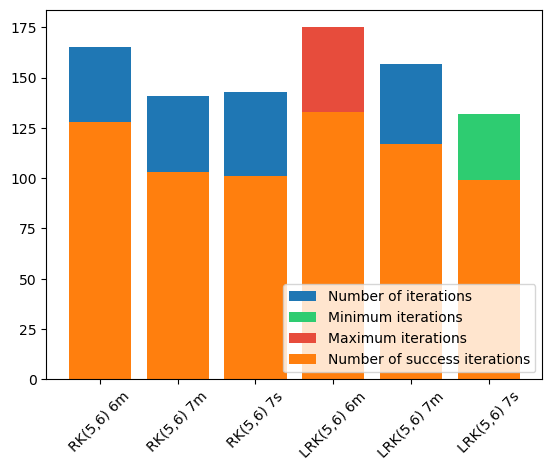

In [13]:
n_iters = []
n_success = []

for tag,name in meths.items():
    data = np.loadtxt("arenstorf_adaptivetimestep_demo/orbit_{}.txt".format(tag))
    t  = data[:,0]
    
    # number of iteration is done by length of of time but we get failed and successed iterations
    n_iters.append(len(t))
    
    # iterations where current time are equals are failed iterations
    n_success.append(len(t[1:][t[:-1]-t[1:] != 0]))

n_iters = np.array(n_iters)
n_success = np.array(n_success)

min_idx = np.argmin(n_iters)
max_idx = np.argmax(n_iters)

plt.bar(meths.values(),n_iters,label="Number of iterations")
plt.bar(list(meths.values())[min_idx],n_iters[min_idx],color="#2ecc71",label="Minimum iterations")
plt.bar(list(meths.values())[max_idx],n_iters[max_idx],color="#e74c3c",label="Maximum iterations")

plt.bar(meths.values(),n_success,label="Number of success iterations")

plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.show()

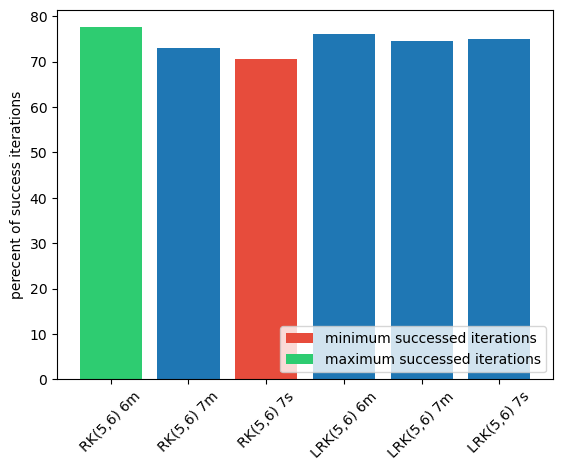

In [14]:
percent = 100*n_success/n_iters

min_idx = np.argmin(percent)
max_idx = np.argmax(percent)

plt.bar(meths.values(),percent)

plt.bar(list(meths.values())[min_idx],percent[min_idx],color="#e74c3c",label="minimum successed iterations")
plt.bar(list(meths.values())[max_idx],percent[max_idx],color="#2ecc71",label="maximum successed iterations")

plt.legend(loc='lower right')
plt.xticks(rotation=45)
plt.ylabel("perecent of success iterations")
plt.show()